In [1]:
import vugrad as vg
import numpy as np

# Question 5

In [2]:
x = vg.TensorNode(np.random.randn(2, 2))
a = vg.TensorNode(np.random.randn(2, 2))
b = vg.TensorNode(np.random.randn(2, 2))
c=a+b


What does c.value contain?

In [3]:
c.value

array([[-0.37443041,  2.90527094],
       [ 0.59149453,  0.39987651]])

In [4]:
print(c.source)
print(c.source.op)

<class 'vugrad.core.Add'>


In [5]:
c.source.inputs[0]

In [6]:
a.grad

array([[0., 0.],
       [0., 0.]])

# Question 6
1) The operation of OpNNode object is defined by the Op abstract class, which can be subclassed to define certain operations. Those operations have to implement *forward* and *backward* methods, as defined in Op interface.

2) It is defined in core.py:287
```python
    class Add(Op):
        """
        Op for element-wise matrix addition.
        """
        @staticmethod
        def forward(context, a, b):
            assert a.shape == b.shape, f'Arrays not the same sizes ({a.shape} {b.shape}).'
            return a + b

```
3) It's done because the computational graph is eagerly executed, it's build on the fly. The graph only defines the flow of the computations, but not their results. OpNode is connected to the output nodes in core.py:212 

```python
    outputs = [TensorNode(value=output, source=opnode) for output in outputs_raw]
    opnode.outputs = outputs
```

# Question 7
```python
    # compute the gradients over the inputs
    ginputs_raw = self.op.backward(self.context, *goutputs_raw)
```

# Question 8

TODO

# Question 9



In [7]:
class ReLU(vg.ops.Op):
    """
    Op for element-wise application of ReLU function
    """

    @staticmethod
    def forward(context, input):
        #print(input.shape)
        relux = input * (input > 0)
        context['relux'] = relux
        return relux

    @staticmethod
    def backward(context, goutput):
        relux = context['relux']
        drelux = np.greater(relux, 0).astype(int)
        return drelux*goutput

def relu(x):
    """ Wrap the sigmoid op in a funciton (just for symmetry with the softmax). """
    return ReLU.do_forward(x)

In [8]:
import numpy as np
import vugrad as vg

# Parse command line arguments

class args:
    lr = 0.0001
    data = 'mnist'
    epochs = 20
    batch_size = 128

# Create a simple neural network.
# This is a `Module` consisting of other modules representing linear layers, provided by the vugrad library.
class MLP(vg.Module):
    """
    A simple MLP with one hidden layer, and a sigmoid non-linearity on the hidden layer and a softmax on the
    output.
    """

    def __init__(self, input_size, output_size, hidden_mult=4):
        """
        :param input_size:
        :param output_size:
        :param hidden_mult: Multiplier that indicates how many times bigger the hidden layer is than the input layer.
        """
        super().__init__()

        hidden_size = hidden_mult * input_size
        # -- There is no common wisdom on how big the hidden size should be, apart from the idea
        #    that it should be strictly _bigger_ than the input if at all possible.

        self.layer1 = vg.Linear(input_size, hidden_size)
        self.layer2 = vg.Linear(hidden_size, output_size)
        # -- The linear layer (without activation) is implemented in vugrad. We simply instantiate these modules, and
        #    add them to our network.

    def forward(self, input):

        assert len(input.size()) == 2

        # first layer
        hidden = self.layer1(input)

        # non-linearity
        hidden = vg.sigmoid(hidden)
        # -- We've called a utility function here, to mimin how this is usually done in pytorch. We could also do:
        #    hidden = Sigmoid.do_forward(hidden)

        # second layer
        output = self.layer2(hidden)

        # softmax activation
        output = vg.logsoftmax(output)
        # -- the logsoftmax computes the _logarithm_ of the probabilities produced by softmax. This makes the computation
        #    of the CE loss more stable when the probabilities get close to 0 (remember that the CE loss is the logarithm
        #    of these probabilities). It needs to be implemented in a specific way. See the source for details.

        return output

    def parameters(self):

        return self.layer1.parameters() + self.layer2.parameters()


class MLP_ReLU(MLP):
    def forward(self, input):

        assert len(input.size()) == 2

        # first layer
        hidden = self.layer1(input)

        # non-linearity
        hidden = relu(hidden)
        # -- We've called a utility function here, to mimin how this is usually done in pytorch. We could also do:
        #    hidden = Sigmoid.do_forward(hidden)

        # second layer
        output = self.layer2(hidden)

        # softmax activation
        output = vg.logsoftmax(output)
        # -- the logsoftmax computes the _logarithm_ of the probabilities produced by softmax. This makes the computation
        #    of the CE loss more stable when the probabilities get close to 0 (remember that the CE loss is the logarithm
        #    of these probabilities). It needs to be implemented in a specific way. See the source for details.

        return output

## Load the data
if args.data == 'synth':
    (xtrain, ytrain), (xval, yval), num_classes = vg.load_synth()
elif args.data == 'mnist':
    (xtrain, ytrain), (xval, yval), num_classes = vg.load_mnist(final=False, flatten=True)
else:
    raise Exception(f'Dataset {args.data} not recognized.')

print(f'## loaded data:')
print(f'         number of instances: {xtrain.shape[0]} in training, {xval.shape[0]} in validation')
print(f' training class distribution: {np.bincount(ytrain)}')
print(f'     val. class distribution: {np.bincount(yval)}')

num_instances, num_features = xtrain.shape


## loaded data:
         number of instances: 55000 in training, 5000 in validation
 training class distribution: [5434 6212 5465 5622 5343 4963 5436 5702 5357 5466]
     val. class distribution: [489 530 493 509 499 458 482 563 494 483]


In [9]:
results = list()
## Create the model.

n, m = xtrain.shape
b = args.batch_size

for nonlinearity, model in [('sigmoid', MLP), ('relu', MLP_ReLU)]:
    ## Instantiate the model
    mlp = model(input_size=num_features, output_size=num_classes)

    print('\n## Starting training')
    for epoch in range(args.epochs):

        print(f'epoch {epoch:03}')

        ## Compute validation accuracy
        o = mlp(vg.TensorNode(xval))
        oval = o.value

        predictions = np.argmax(oval, axis=1)
        num_correct = (predictions == yval).sum()
        acc = num_correct / yval.shape[0]

        o.clear() # gc the computation graph
        print(f'       accuracy: {acc:.4}')

        cl = 0.0 # running sum of the training loss

        # We loop over the data in batches of size `b`
        for fr in range(0, n, b):

            # The end index of the batch
            to = min(fr + b, n)

            # Slice out the batch and its corresponding target values
            batch, targets = xtrain[fr:to, :], ytrain[fr:to]

            # Wrap the inputs in a Node
            batch = vg.TensorNode(value=batch)

            outputs = mlp(batch)
            loss = vg.logceloss(outputs, targets)
            # -- The computation graph is now complete. It consists of the MLP, together with the computation of
            #    the scalar loss.
            # -- The variable `loss` is the TensorNode at the very top of our computation graph. This means we can call
            #    it to perform operations on the computation graph, like clearing the gradients, starting the backpropgation
            #    and clearing the graph.
            # -- Note that we set the MLP up to produce log probabilties, so we should compute the CE loss for these.

            cl += loss.value
            # -- We must be careful here to extract the _raw_ value for the running loss. What would happen if we kept
            #    a running sum using the TensorNode?

            # Start the backpropagation
            loss.backward()

            # pply gradient descent
            for parm in mlp.parameters():
                parm.value -= args.lr * parm.grad
                # -- Note that we are directly manipulating the members of the parm TensorNode. This means that for this
                #    part, we are not building up a computation graph.

            # -- In Pytorch, the gradient descent is abstracted away into an Optimizer. This allows us to build slightly more
            #    complexoptimizers than plain graident descent.

            # Finally, we need to reset the gradients to zero ...
            loss.zero_grad()
            # ... and delete the parts of the computation graph we don't need to remember.
            loss.clear()
        results.append({
                        'epoch' : epoch,
                        'accuracy' : acc,
                        'loss' : cl/n,
                        'method' : nonlinearity,
                        'dataset' : args.data
                    })
        print(f'   running loss: {cl/n:.4}')

            




## Starting training
epoch 000
       accuracy: 0.0998
   running loss: 0.4009
epoch 001
       accuracy: 0.9496
   running loss: 0.2092
epoch 002
       accuracy: 0.9596
   running loss: 0.1586
epoch 003
       accuracy: 0.9634
   running loss: 0.1262
epoch 004
       accuracy: 0.966
   running loss: 0.1028
epoch 005
       accuracy: 0.9654
   running loss: 0.08435
epoch 006
       accuracy: 0.969
   running loss: 0.07036
epoch 007
       accuracy: 0.9692
   running loss: 0.0593
epoch 008
       accuracy: 0.9702
   running loss: 0.05076
epoch 009
       accuracy: 0.9696
   running loss: 0.04395
epoch 010
       accuracy: 0.9706
   running loss: 0.03853
epoch 011
       accuracy: 0.971
   running loss: 0.03422
epoch 012
       accuracy: 0.9722
   running loss: 0.03068
epoch 013
       accuracy: 0.9722
   running loss: 0.02774
epoch 014
       accuracy: 0.9722
   running loss: 0.0253
epoch 015
       accuracy: 0.972
   running loss: 0.0233
epoch 016
       accuracy: 0.9716
   running l

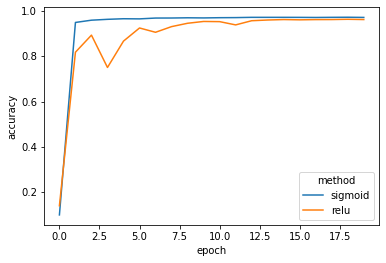

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
df = pd.DataFrame(results)
sns.lineplot(data=df, x='epoch', y='accuracy', hue='method')
plt.savefig('simrelu.png')

for f in ('sigmoid', 'relu'):
    print(f, df[df.method == f].max()['accuracy'])

# Question 10

In [13]:
results = list()
## Create the model.

n, m = xtrain.shape
b = args.batch_size

for nonlinearity, model in [('sigmoid', MLP), ('relu', MLP_ReLU)]:
    ## Instantiate the model
    mlp = model(input_size=num_features, output_size=num_classes, hidden_mult=8)

    print('\n## Starting training')
    for epoch in range(args.epochs):

        print(f'epoch {epoch:03}')

        ## Compute validation accuracy
        o = mlp(vg.TensorNode(xval))
        oval = o.value

        predictions = np.argmax(oval, axis=1)
        num_correct = (predictions == yval).sum()
        acc = num_correct / yval.shape[0]

        o.clear() # gc the computation graph
        print(f'       accuracy: {acc:.4}')

        cl = 0.0 # running sum of the training loss

        # We loop over the data in batches of size `b`
        for fr in range(0, n, b):

            # The end index of the batch
            to = min(fr + b, n)

            # Slice out the batch and its corresponding target values
            batch, targets = xtrain[fr:to, :], ytrain[fr:to]

            # Wrap the inputs in a Node
            batch = vg.TensorNode(value=batch)

            outputs = mlp(batch)
            loss = vg.logceloss(outputs, targets)
            # -- The computation graph is now complete. It consists of the MLP, together with the computation of
            #    the scalar loss.
            # -- The variable `loss` is the TensorNode at the very top of our computation graph. This means we can call
            #    it to perform operations on the computation graph, like clearing the gradients, starting the backpropgation
            #    and clearing the graph.
            # -- Note that we set the MLP up to produce log probabilties, so we should compute the CE loss for these.

            cl += loss.value
            # -- We must be careful here to extract the _raw_ value for the running loss. What would happen if we kept
            #    a running sum using the TensorNode?

            # Start the backpropagation
            loss.backward()

            # pply gradient descent
            for parm in mlp.parameters():
                parm.value -= args.lr * parm.grad
                # -- Note that we are directly manipulating the members of the parm TensorNode. This means that for this
                #    part, we are not building up a computation graph.

            # -- In Pytorch, the gradient descent is abstracted away into an Optimizer. This allows us to build slightly more
            #    complexoptimizers than plain graident descent.

            # Finally, we need to reset the gradients to zero ...
            loss.zero_grad()
            # ... and delete the parts of the computation graph we don't need to remember.
            loss.clear()
        results.append({
                        'epoch' : epoch,
                        'accuracy' : acc,
                        'loss' : cl/n,
                        'method' : nonlinearity,
                        'dataset' : args.data
                    })
        print(f'   running loss: {cl/n:.4}')

            



## Starting training
epoch 000
       accuracy: 0.1098
   running loss: 0.3616
epoch 001
       accuracy: 0.9534
   running loss: 0.1637
epoch 002
       accuracy: 0.9636
   running loss: 0.111
epoch 003
       accuracy: 0.9654
   running loss: 0.07933
epoch 004
       accuracy: 0.9678
   running loss: 0.05886
epoch 005
       accuracy: 0.969
   running loss: 0.04537
epoch 006
       accuracy: 0.9696
   running loss: 0.03613
epoch 007
       accuracy: 0.9706
   running loss: 0.02965
epoch 008
       accuracy: 0.9716
   running loss: 0.02496
epoch 009
       accuracy: 0.972
   running loss: 0.02144
epoch 010
       accuracy: 0.9718
   running loss: 0.01872
epoch 011
       accuracy: 0.9724
   running loss: 0.01656
epoch 012
       accuracy: 0.9728
   running loss: 0.01481
epoch 013
       accuracy: 0.9732
   running loss: 0.01337
epoch 014
       accuracy: 0.9732
   running loss: 0.01216
epoch 015
       accuracy: 0.9734
   running loss: 0.01114
epoch 016
       accuracy: 0.974
   runn

sigmoid 0.9744
relu 0.966


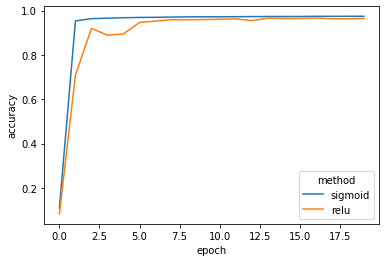

In [14]:
plt.figure()
df = pd.DataFrame(results)
sns.lineplot(data=df, x='epoch', y='accuracy', hue='method')
plt.savefig('simrelu_8xhidden.png')

for f in ('sigmoid', 'relu'):
    print(f, df[df.method == f].max()['accuracy'])